In [1]:
import numpy as np
from scipy.stats import ks_2samp, ks_1samp, kstest
import json
import pandas as pd
import matplotlib.pyplot as plt
from random import choices
import os
from scipy.stats import bernoulli
from scipy.stats import zipf

In [2]:
import re
def match_regex_array(files, regex):
    matches = [re.findall(regex, f) for f in files]
    matches = ["./sim_results/" + m[0] for m in matches if len(m) > 0 ]
    return matches

In [3]:
# Apply KS-test using a large number of samples from the reference distribution 
# and a small sample from a "test" (in this case, the Network-Aware) distribution multiple times
# Each test sample represents a bot consuming contents from NA-distribution
# Function returns the mean of the p_values for all KS-tests performed for each bot
# and the proportion of null hypothesis rejection, i.e., samples were not generated from the same distribution
def covertness_kstest(ref_dist, test_dist, population, ref_dist_size=10**6, test_dist_size=10**3, N_bots = 100, rounds=30):
    p_values_mean_rounds = []
    rejection_proportions_rounds = []
    ref_dist_large_samples = choices(population, ref_dist, k=ref_dist_size)
    for i in range(rounds):
        p_values = []        
        null_hypothesis_rejections = 0
        for j in range(N_bots):
            test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
            ks = ks_2samp(ref_dist_large_samples, test_dist_samples)
            p_values.append(ks.pvalue)
            if (ks.pvalue < 0.05):
                null_hypothesis_rejections += 1
        p_values_mean = np.mean(p_values)
        null_hypothesis_rejections /= N_bots

        p_values_mean_rounds.append(p_values_mean)
        rejection_proportions_rounds.append(np.mean(null_hypothesis_rejections))
    return p_values_mean_rounds, rejection_proportions_rounds

In [4]:
# aggregated mode
def covertness_kstest_aggregate(baseline_samples, test_dist, population, test_dist_size=10**3, N_bots = 100, rounds=30):
    p_values_rounds = []
    null_hypothesis_rejections = 0
    for i in range(rounds):
        # print("round ", i, end=' ')
        test_agg_samples = []
        for j in range(N_bots):
            test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
            test_agg_samples += test_dist_samples
        ks = ks_2samp(baseline_samples, test_agg_samples)
        if (ks.pvalue < 0.05):
            null_hypothesis_rejections += 1
        p_values_rounds.append(ks.pvalue)        
    return p_values_rounds, null_hypothesis_rejections/rounds

In [5]:
path = "/home/mateus/NFR-master/Simulator/sim_results/"
data_lastfm = json.load(open(path + "sim_results_Ulastfm_pop0_a0.5_N2_C5_CPtop_Q0.5_L40.json"))
lastfm_size = len(data_lastfm['p0'])
data_movielens = json.load(open(path + "sim_results_Umovielens1k_pop1_a0.5_N10_C10_CPtop_Q0.9_L40.json"))
movielens_size = len(data_movielens['p0'])
population_movielens = np.arange(movielens_size)
population_lastfm = np.arange(lastfm_size)

In [158]:
# random walker

def covertness_kstest_random_walker(baseline_samples, p0, R, N, alpha, N_bots, contents_per_bot, rounds, R_top=False):
    R = np.array(R)
    p0 = np.array(p0)
    population = np.arange(len(p0))
    proportions = []
    for i in range(rounds):
        null_hypothesis_rejections = 0
        for j in range(N_bots):
            consumed = []
            first_content = choices(population, p0, k=1)[0]            
            consumed.append(first_content)
            current_content = first_content
            for k in range(contents_per_bot):
                follow_recommendation = bernoulli.rvs(p=alpha, size=1)[0]
                if follow_recommendation:
                    ri = R[current_content, :]
                    ri_idx = np.where(ri > 0)[0] # index of > 0 elements
#                     ri = ri[ri > 0] # values of > 0 elements
#                     ri = pd.Series(data = ri, index = ri_idx)                                    
#                     ri = ri.sort_values(ascending=False)
#                     ri = ri.iloc[:N]
#                     content = choices(population=ri.index, weights=ri.values, k=1)[0]
                    content = choices(population=ri_idx, weights=np.repeat(1/len(ri_idx), len(ri_idx)), k=1)[0]
                else:
                    content = choices(population, p0, k=1)[0]
                current_content = content
                consumed.append(content) 
#             print(consumed)
#             return consumed
            ks = ks_2samp(baseline_samples, consumed)
            if (ks.pvalue < 0.05):
                null_hypothesis_rejections += 1
        proportions.append(null_hypothesis_rejections/N_bots)
    return proportions
                

In [99]:
baseline_samples = choices(population_movielens, data_movielens['pi_bs'], k=10**5)
na_samples = choices(population_movielens, data_movielens['pi_final_NA'], k=10**5)

In [184]:
N = 10
alpha = 0.5
N_bots = 1
contents_per_bot = 10000
proportions_rw = covertness_kstest_random_walker(na_samples, data_movielens['p0'], data_movielens['R_top'], N, alpha, N_bots, contents_per_bot, 10, R_top=False)


In [185]:
np.mean(proportions_rw)

1.0

(array([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

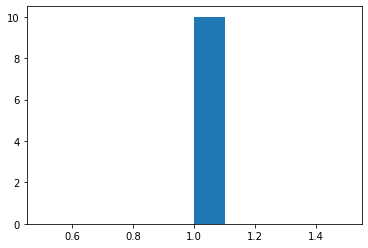

In [115]:
plt.hist(proportions_rw)

In [261]:
# aggregated mode
def covertness_kstest_aggregate_random_contents_per_bot(baseline_samples, test_dist, population, contents_per_user_population, contents_per_user_dist, N_bots = 100, rounds=30):
    p_values_rounds = []
    null_hypothesis_rejections = 0
    for i in range(rounds):
        # print("round ", i, end=' ')
        test_agg_samples = []
        for j in range(N_bots):
            test_dist_size = choices(contents_per_user_population, contents_per_user_dist, k=1)[0]
            test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
            test_agg_samples += test_dist_samples
        # print(len(test_agg_samples), end=",")
        ks = ks_2samp(baseline_samples, test_agg_samples)
        if (ks.pvalue < 0.05):
            null_hypothesis_rejections += 1
        p_values_rounds.append(ks.pvalue)        
    return p_values_rounds, null_hypothesis_rejections/rounds

In [206]:
# Consistency Check - we should see a small p-value when comparing samples from pi_NA 
# and a high p-value when using samples from pi_bs
# print("KStest between large samples bs and a small sample bs (expected high p-value)")
# p_values_means, proportion_means = covertness_kstest(data_movielens['pi_bs'], data_movielens['pi_bs'], population_movielens, ref_dist_size=10**3, test_dist_size=10**2, N_bots=20)
# print("p_value: " ,np.mean(p_values_means))
# print(np.mean(proportion_means))
print("KStest between large samples bs and a small sample NA (expected low p-value)")
baseline_samples = choices(population_movielens, data_movielens['pi_bs'], k=10**4)
p_values, proportion = covertness_kstest_aggregate(baseline_samples, data_movielens['pi_final_NA'], population_movielens, test_dist_size=20, N_bots=10, rounds=30)
proportion
# print("p_value: ", np.mean(p_values_means))
# print(np.mean(proportion_means))


KStest between large samples bs and a small sample NA (expected low p-value)


0.6333333333333333

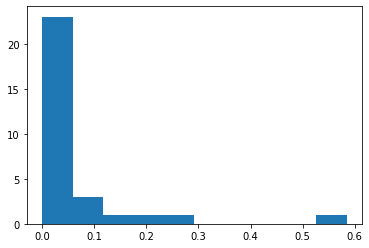

In [10]:
# It should have the shape of a normal distribution
plt.hist(p_values)
plt.show()

In [12]:
# It should have the shape of a normal distribution
# plt.hist(proportion_means)
# plt.show()

In [70]:
def ci_proportion(p_hat, n):
    std_hat = np.sqrt((p_hat*(1-p_hat))/n)
    lower = p_hat - 1.96*std_hat
    upper = p_hat + 1.96*std_hat
    return lower, p_hat, upper

In [242]:
# vc = df['user id'].value_counts()
# unique, counts = np.unique(vc, return_counts=True)
# unique_counts = np.asarray((unique, counts)).T
# choices(unique, counts, k=10)

In [72]:
from os.path import exists
def save_confidence_intervals(cis, test_dist_sizes, rounds, bots):
    filename = "confidence_interval_test_size" + "tds" + str(test_dist_sizes[0]) + \
        "-" + str(test_dist_sizes[-1]) + "_rounds_" + str(rounds) + \
        "_bots_" + str(bots) + ".txt"
    if (not exists(filename)):
        lowers = np.array([cis[i][0] for i in range(len(cis))])
        means = np.array([cis[i][1] for i in range(len(cis))])
        uppers = np.array([cis[i][2] for i in range(len(cis))])
        f = open(filename, "w")
        n_intervals = len(means)
        for i in range(n_intervals):            
            f.write(str(lowers[i]) + "," + str(means[i]) + "," + \
                    str(uppers[i]) + "\n")
        f.close()
    else:
        print("{} file already exists".format(filename))
    

In [96]:
test_dist_sizes = np.linspace(10, 150, 10).astype(int)
confidence_intervals = []
ref_dist_size=10**3
ref_dist = data_movielens['pi_bs']
ref_dist_samples = choices(population_movielens, ref_dist, k=ref_dist_size)
nrounds = 100
n_bots = [10, 20, 30]
alpha = 0.5
N = 10
# n_bots = np.linspace(10, 50, 40).astype(int)
cis = []
for nbots in n_bots:
    print(nbots, end=',')
    cis = []
    for tds in test_dist_sizes:
        print(tds, end=',')
        contents_per_bot = tds
        proportions = covertness_kstest_random_walker(ref_dist_samples,\
                                                   data_movielens['pi_bs'], \
                                                      data_movielens['p0'], \
                                                   data_movielens['R_NA'], \
                                                   N, alpha, nbots,\
                                                   contents_per_bot,\
                                                   nrounds)
        cis.append(np.array(ci_proportion(np.mean(proportions), nrounds)))
    save_confidence_intervals(cis, [10, 50], nrounds, nbots)

10,10,25,41,56,72,87,103,118,134,150,20,10,25,41,56,72,87,103,118,134,150,30,10,25,41,56,72,87,103,118,134,150,

In [262]:
# test_dist_sizes = np.linspace(10, 50, 40).astype(int)
# proportions = []
# confidence_intervals = []
# ref_dist_size=10**3
# ref_dist = data_movielens['pi_bs']
# ref_dist_samples = choices(population_movielens, ref_dist, k=ref_dist_size)
# vcs = df['user id'].value_counts() 
# # unique_counts = np.asarray((unique, counts)).T
# contents_per_user_population, contents_per_user_dist = np.unique(vcs, return_counts=True)
# nrounds = 100
# # n_bots = [10, 20, 30]
# n_bots = np.linspace(10, 50, 40).astype(int)
# cis = []
# for nbots in n_bots:
#     print(nbots, end=',')
#     # cis = []
#     # for tds in test_dist_sizes:
#         # print(tds, end=',')
#     p_values, proportion = covertness_kstest_aggregate_random_contents_per_bot(\
#                                                ref_dist_samples, \
#                                                data_movielens['pi_final_NA'], \
#                                                population_movielens, \
#                                                contents_per_user_population//10,
#                                                contents_per_user_dist,
#                                                N_bots=nbots, rounds=nrounds)
#     proportions.append(proportion)
#     cis.append(np.array(ci_proportion(proportion, nrounds)))
# save_confidence_intervals(cis, [0, 700], nrounds, nbots)

10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,50,

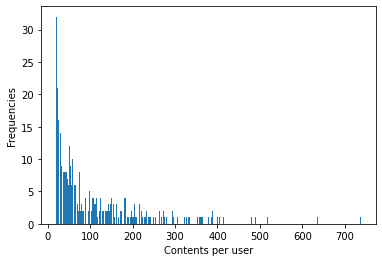

In [281]:
plt.bar(contents_per_user_population, contents_per_user_dist)
plt.xlabel("Contents per user")
plt.ylabel("Frequencies")
plt.savefig("contents_per_user_freq.png")

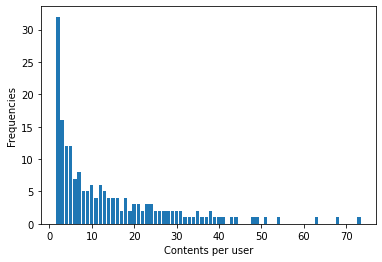

In [282]:
plt.bar(contents_per_user_population//10, contents_per_user_dist)
plt.xlabel("Contents per user")
plt.ylabel("Frequencies")
plt.savefig("contents_per_user_freq_div_10.png")

In [263]:
# save_confidence_intervals(cis, test_dist_sizes, nrounds, nbots)

In [91]:
def plot_confidence_intervals(x, filename, fig, ax, label, color):
    try:
        f = open(filename, "r")
        cis = np.array([np.array(line.rstrip().split(",")).astype(float) for line in f.readlines()])        
        lowers = np.around(cis[:, 0], decimals=2)
        means = np.around(cis[:, 1], decimals=2)
        uppers = np.around(cis[:, 2], decimals=2)
        print(uppers)
        if not fig or not ax:
            fig, ax = plt.subplots()
        ax.plot(x, means, label=label, color=color)
        ax.fill_between(x, lowers, uppers, color=color, alpha=.1)
        plt.xlabel("Contents per bot")
        plt.ylabel("Proportion of null hypothesis rejections")
        # plt.savefig("proportions_nbots30.png")
        # plt.show()
    except Exception as e:
        print(e)

[0.54 0.62 0.71 0.66 0.71 0.74 0.74 0.84 0.87 0.78 0.84 0.84 0.86 0.84
 0.92 0.89 0.9  0.93 0.95 0.95 0.98 0.9  0.99 0.97 0.97 0.97 0.95 0.97
 0.97 0.99 1.01 0.98 1.01 1.   1.   1.01 1.01 1.01 1.01 1.01]


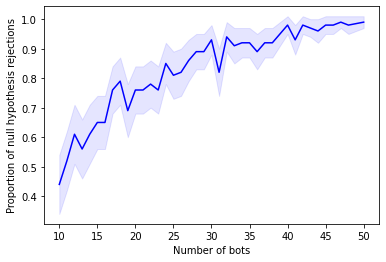

In [272]:
fig, ax = plt.subplots()
plot_confidence_intervals(n_bots, "confidence_interval_random_test_sizetds0-700_rounds_100_bots_50.txt", fig, ax, '', 'b')
plt.savefig("proportions_nbots.png")

[0.27 0.38 0.51 0.61 0.67 0.74 0.83 0.85 0.86 0.93]
[0.25 0.37 0.5  0.6  0.68 0.73 0.8  0.84 0.88 0.91]
[0.25 0.39 0.49 0.58 0.69 0.74 0.81 0.84 0.88 0.92]


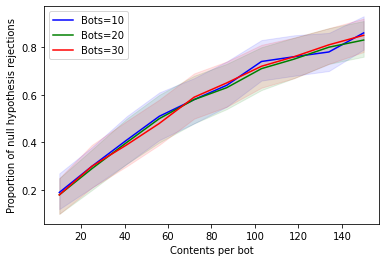

In [98]:
fig, ax = plt.subplots()
plot_confidence_intervals(test_dist_sizes, "confidence_interval_test_sizetds10-50_rounds_100_bots_10.txt", fig, ax, 'Bots=10', 'b')
plot_confidence_intervals(test_dist_sizes, "confidence_interval_test_sizetds10-50_rounds_100_bots_20.txt", fig, ax, 'Bots=20', 'g')
plot_confidence_intervals(test_dist_sizes, "confidence_interval_test_sizetds10-50_rounds_100_bots_30.txt", fig, ax, 'Bots=30', 'r')
plt.legend()
plt.savefig("proportions.png")

In [23]:
# for the not aggregated case
# test_dist_sizes = np.linspace(10, 40, 4).astype(int)
# pvalues_mean_sample = []
# proportion_mean_sample = []
# confidence_intervals = []
# for tds in test_dist_sizes:
#     print(tds)
#     p_values_means, proportion_means = covertness_kstest(data_movielens['pi_bs'], data_movielens['pi_final_NA'], population_movielens, ref_dist_size=10**4, test_dist_size=tds, N_bots=50, rounds=30)
#     pvalues_mean_sample.append(p_values_means)
#     proportion_mean_sample.append(proportion_means)

In [ ]:
# Random Walker



In [ ]:
files = os.listdir('./sim_results/')
movielens_simulations_files = match_regex_array(files, r'sim_results_Umovielens.*')
lastfm_simulations_files = match_regex_array(files, r'sim_results_Ulastfm.*')
ks_movielens = []
i = 0
end = movielens_size
for filename in movielens_simulations_files:
    print("{}/{}".format(i, end))
    kstest_file(filename)
    i+=1

0/1060
1/1060
2/1060
3/1060
4/1060
5/1060
6/1060
7/1060
8/1060
9/1060
10/1060
11/1060
12/1060
13/1060
14/1060
15/1060
16/1060
